# imports

In [65]:
# !pip install pycocoevalcap

In [146]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torchinfo
import json
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import random
import spacy
import pickle
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.spice.spice import Spice
import numpy as np
import skimage.transform
import matplotlib.cm as cm

# set the device

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# dataset hyperparameters

In [68]:
batch_num = 32
# If num_workers = 0, the data loading happens in the main process (sequentially, which can be slow)
# If num_workers > 0, PyTorch will use multiple subprocesses to load the data concurrently
workers = 0
# Set to true when using GPU to prevent copying data from host memory (CPU RAM) to device memory (GPU)
pin_memory = True

# Collate

In [69]:
# Responsible for converting the individual data items returned by the __getitem__ method of custom Dataset 
# into a single batch that can be passed to the model during training or evaluation
class MyCollate:
    def __init__(self, pad_idx, split):
        self.pad_idx = pad_idx
        self.split= split

    def __call__(self, batch):
        # Get the image and change it's dimention [C, H, W] → [1, C, H, W]
        imgs = [item[0].unsqueeze(0) for item in batch]
        targets = [item[1] for item in batch]
        lengths = [item[2] for item in batch]
        
        # Concatenate all images along dim=0 to form a batch tensor of shape [batch_size, C, H, W]
        imgs = torch.cat(imgs, dim=0)
        # Use pad_sequence to pad variable-length sequences to the same length
        # batch_first=True argument means the output tensor has shape (batch_size, max_seq_length)
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        output = (imgs, targets, torch.tensor(lengths))
        
        if self.split != "train":
            allcaps = [item[3] for item in batch]  # List[List[List[int]]]
        
            # Flatten all captions across the batch
            all_captions_flat = [torch.tensor(cap) for img_caps in allcaps for cap in img_caps]
            
            # Pad ALL captions to the same max length
            padded_captions_flat = pad_sequence(all_captions_flat, batch_first=True, padding_value=self.pad_idx)
            
            # Reshape back to (batch_size, num_captions_per_image, max_len)
            num_captions_per_image = len(allcaps[0])  # e.g., 5 captions per image
            allcaps_tensor = padded_captions_flat.view(len(batch), num_captions_per_image, -1)
            
            output += (allcaps_tensor,)
        return output

# Vocabulary

In [70]:
# Download with: python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, tokens):
        frequencies = Counter()

        for cap_tokens in tokens:
            # Update word frequency
            frequencies.update(cap_tokens)

        # Get the words with frequency more than a threshold
        words = [w for w in frequencies.keys() if frequencies[w] > self.freq_threshold]
        # Use v + 4 because indexes 0 to 3 are already taken
        self.stoi.update({k: v + 4 for v, k in enumerate(words)})
        self.itos.update({v + 4: k for v, k in enumerate(words)})

    def numericalize(self, text, tokenized_text):
        # Use tokens from dataset or use spacy
        # tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

    def textualize(self, embedding):
        # Convert tensor to list
        embedding_list = embedding.tolist()
        return " ".join(self.itos[num] for num in embedding_list)

    def tokenize_caption(self, caption, tokens):
        numericalized_caption = [self.stoi["<start>"]]
        numericalized_caption += self.numericalize(caption, tokens)
        numericalized_caption.append(self.stoi["<end>"])
        return torch.tensor(numericalized_caption)

# load data

In [71]:
class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_dict, tokens, split, captions_per_image=5, transform=None, freq_threshold=5, vocab=None):
        self.image_folder = image_folder
        self.captions_per_image = captions_per_image
        self.captions_dict = self.sample_captions(captions_dict)  # Dictionary with {image_name: [caption1, caption2, ...]}
        self.tokens = tokens
        self.split = split
        self.captions = [caption for captions in captions_dict.values() for caption in captions] # all captions together
        self.caption_lengths = [len(token) + 2 for token in self.tokens] # + 2 to consider start and end tokens
        self.image_names = list(captions_dict.keys())  # List of unique image names
        self.transform = transform
        # Prevent rebuilding vocab for validation and test to avoid words the model has never seen before
        # or, worse, assign different indices to the same word
        if vocab is not None:
            self.vocab = vocab
        else:
            self.vocab = Vocabulary(freq_threshold) # Initialize vocabulary and build vocab
            self.vocab.build_vocabulary(self.tokens) # self.vocab.build_vocabulary(self.captions)

    # Based on image
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)

        # Open image
        image = Image.open(image_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get all captions for the image
        captions = self.captions_dict[image_name]

        # Get one of the captions randomly for training
        random_idx = random.randrange(len(captions))
        caption = captions[random_idx]
        caption_length = self.caption_lengths[idx * self.captions_per_image + random_idx]

        numericalized_caption = self.vocab.tokenize_caption(caption, self.tokens[idx * self.captions_per_image + random_idx])

        output = (image, numericalized_caption, caption_length)
        if self.split != "train":
            tokenized_captions = [self.vocab.tokenize_caption(cap, self.tokens[idx * self.captions_per_image + i]) for i, cap in enumerate(captions)]
            output += (tokenized_captions,)
        return output         

    # # Based on caption
    # def __len__(self):
    #     return len(self.captions)

    # def __getitem__(self, idx):
    #     image_name = self.image_names[idx // self.captions_per_image]
    #     image_path = os.path.join(self.image_folder, image_name)

    #     # Open image
    #     image = Image.open(image_path).convert("RGB")
        
    #     # Apply transformations
    #     if self.transform:
    #         image = self.transform(image)

    #     caption = self.captions[idx]

    #     caption_length = self.caption_lengths[idx]

    #     numericalized_caption = self.vocab.tokenize_caption(caption, self.tokens[idx])

    #     # all captions for validation or testing ?
    #     return image, numericalized_caption, caption_length

    def sample_captions(self, img_captions):
        # Set a specific number of captions for all images
        modified_captions_dict = {}
        for img, captions in img_captions.items():
            if len(captions) < self.captions_per_image:
                new_captions = captions + [random.choice(captions) for _ in range(self.captions_per_image - len(captions))]
            else:
                new_captions = random.sample(captions, k=self.captions_per_image)
            
            # Sanity check
            assert len(new_captions) == self.captions_per_image
            modified_captions_dict[img] = new_captions        
            
        return modified_captions_dict

In [72]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"  
image_folder = "/kaggle/input/flickr8kimagescaptions/flickr8k/images/"
# karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr30k.json" 
karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr8k.json"

In [73]:
# Load Karpathy split JSON
with open(karpathy_json_path, "r") as f:
    data = json.load(f)

# Organize images by split
split_data = {"train": {}, "val": {}, "test": {}}
token_data = {"train": [], "val": [], "test": []}

for img in data["images"]:
    image_name = img["filename"]
    split = img["split"]  # Can be "train", "val", or "test"
    
    captions = [sent["raw"] for sent in img["sentences"]]  # Extract all 5 captions
    split_data[split][image_name] = captions  # Store in respective split
    
    tokens = [sent["tokens"] for sent in img["sentences"]]  # Extract all tokens
    token_data[split] += tokens

# Now we have:
# split_data["train"], split_data["val"], split_data["test"]


In [74]:
# Load different splits
train_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["train"], 
    token_data["train"], 
    split="train",
    captions_per_image=5,
    transform=transform, 
    freq_threshold=3
)
# Save the vocab to reuse
shared_vocab = train_dataset.vocab
# Save
with open('vocab.pkl', 'wb') as f:
    pickle.dump(shared_vocab, f)

val_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["val"], 
    token_data["val"], 
    split="val",
    captions_per_image=5,
    transform=transform,
    freq_threshold=3,
    vocab=shared_vocab
)
test_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["test"], 
    token_data["test"], 
    split="test",
    captions_per_image=5,
    transform=transform,
    freq_threshold=3,
    vocab=shared_vocab
)

pad_idx = shared_vocab.stoi["<pad>"]
# Create DataLoaders
train_loader = DataLoader(train_dataset, 
                          collate_fn=MyCollate(pad_idx=pad_idx, split="train"), 
                          batch_size=batch_num, 
                          shuffle=True, 
                          num_workers=workers,
                          pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, 
                        collate_fn=MyCollate(pad_idx=pad_idx, split="val"), 
                        batch_size=batch_num, 
                        shuffle=False, 
                        num_workers=workers,
                        pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, 
                         collate_fn=MyCollate(pad_idx=pad_idx, split="test"), 
                         batch_size=1, 
                         shuffle=False, 
                         num_workers=workers, 
                         pin_memory=pin_memory)

# visualize data

Batch Size: 32
Image Tensor Shape: torch.Size([32, 3, 256, 256])
First Caption: tensor([  1,   4, 181,  30, 121,  41, 920, 110, 663,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0])
First caption converted: <start> a group of men playing lacrosse at night <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
First caption length: 10


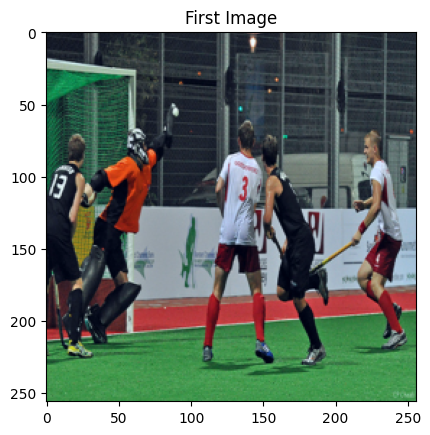

In [75]:
# Test the dataloader
# Fetch one batch
images, captions, caplens = next(iter(train_loader))

print(f"Batch Size: {len(images)}")
print(f"Image Tensor Shape: {images.shape}")  # Should be [batch_size, 3, 256, 256]
image = images[0].permute(1, 2, 0).numpy()
image = image * 0.225 + 0.45  # De-normalize
plt.title("First Image")
plt.imshow(image)
print(f"First Caption: {captions[0]}")
text_caption = shared_vocab.textualize(captions[0])
print(f"First caption converted: {text_caption}")
print(f"First caption length: {caplens[0]}")

In [76]:
def get_all_caps(dataset, idx):
    image_name = dataset.image_names[idx]
    return dataset.captions_dict[image_name]

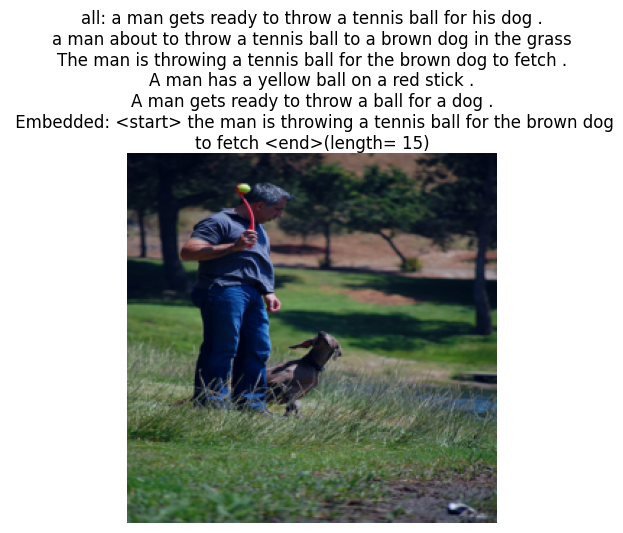

In [77]:
# Visualize a sample
def show_sample(dataset, idx):
    image, caption, caption_length = dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    image = image * 0.225 + 0.45  # De-normalize
    text_caption = dataset.vocab.textualize(caption)
    all_caps = "\n".join(get_all_caps(dataset, idx))
    plt.imshow(image)
    # Use this when the idx is for images not captios
    plt.title(f'all: {all_caps}\n Embedded: {text_caption}(length= {str(caption_length)})', fontsize=12, wrap=True)
    # plt.title(f'\n Embedded: {text_caption}(length= {str(caption_length)})', fontsize=12, wrap=True)
    plt.axis('off')
    plt.show()

show_sample(train_dataset, random.randint(0, len(train_dataset)))

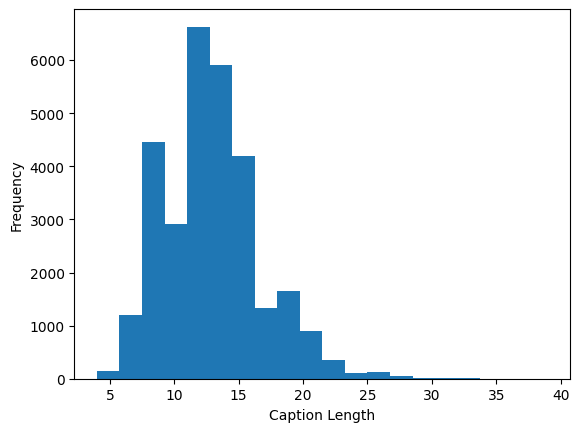

In [78]:
# Caption Length Analysis
caption_lengths = train_dataset.caption_lengths
plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


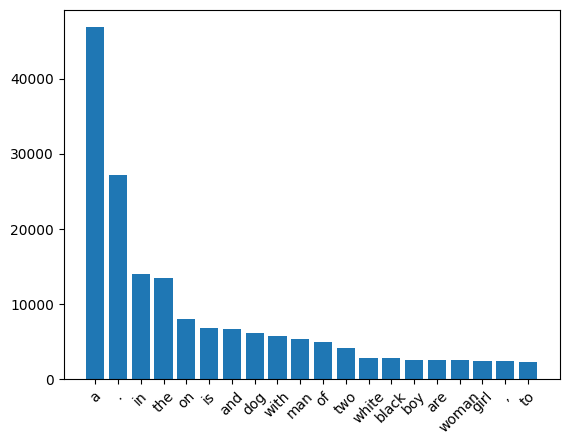

In [79]:
# Word Frequency
all_captions = [caption for caption in train_dataset.captions]

nltk.download('punkt')
all_words = nltk.tokenize.word_tokenize(" ".join(all_captions).lower())
word_freq = Counter(all_words)

# Plot top 20 words
plt.bar(*zip(*word_freq.most_common(20)))
plt.xticks(rotation=45)
plt.show()

# model

In [80]:
# model = models.resnet101(pretrained=True)
# # model = models.vgg16(pretrained=True) 
# # model = models.maxvit_t(pretrained=True) 
# model = models.efficientnet_b0(pretrained=True)
# # model = models.inception_v3(pretrained=True)

# # model = models.mobilenet_v3_small(pretrained=True)
# # model = models.densenet201(pretrained=True)
# print(torchinfo.summary(model, input_size=(4, 3, 256, 256)))

In [81]:
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"Total Parameters: {total_params:,}")
# print(f"Trainable Parameters: {trainable_params:,}")

# for name, layer in model.named_children():
#     print(name, ":", layer)

In [107]:
# Feature extractor
class Encoder(nn.Module):
    def __init__(self, fine_tune=True):
        super(Encoder, self).__init__()
        self.fine_tune = fine_tune

        # to avoid warnings
        # from torchvision.models import resnet101, ResNet101_Weights
        # weights=ResNet101_Weights.DEFAULT
        # model = resnet101(weights=weights)
        
        # model = models.resnet101(pretrained=True)
        # # Remove linear and pool layers (since we're not doing classification)
        # modules = list(model.children())[:-2]
        # # nn.Sequential allows you to chain layers together without writing a forward pass manually
        # self.model = nn.Sequential(*modules)

        
        # model = models.inception_v3(pretrained=True)

        
        # model = models.maxvit_t(pretrained=True) 
        # self.model = model.stages


        # to avoid warnings
        # from torchvision.models import vgg16, VGG16_Weights
        # weights=VGG16_Weights.DEFAULT
        # model = models.vgg16(weights=weights)
        
        # model = models.vgg16(pretrained=True)

        # # to avoid warnings
        from torchvision.models import EfficientNet_B0_Weights
        weights = EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        
        # model = models.efficientnet_b0(pretrained=True)
        self.model = model.features
        
        self.set_grad()
    
    def forward(self, images):
        x = self.model(images) # (batch_size, encoder_dim, image_size/32, image_size/32) => [4, 2048, 8, 8]
        x = x.permute(0, 2, 3, 1)
        return x
        
    def set_grad(self):
        # UNFREEZE only the last few layers (4th ResNet block)
        for name, param in self.model.named_parameters():
            # "8." for efficientnet_b0
            # "layer4" for resnet101
            # "features.24" for vgg16
            # "stages.3" for maxvit_t
            if "8." in name:  # Last residual block (closest to output)
                param.requires_grad = self.fine_tune  # Trainable
            else:
                param.requires_grad = False  # Frozen
        

In [108]:
model = Encoder()
print(f'image feature vector shape: {model(torch.randn(1, 3, 256, 256)).shape}')

image feature vector shape: torch.Size([1, 8, 8, 1280])


In [104]:
# attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, decoder_hidden):
        # encoder_out => (batch_size, num_pixels, encoder_dim)
        # decoder_hidden => (batch_size, decoder_dim)
        # convert to attention dim
        att1 = self.encoder_att(encoder_out) # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden) # (batch_size, attention_dim)
        # (batch_size, num_pixels, attention_dim) => (batch_size, num_pixels, 1) => (batch_size, num_pixels)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2) 
        # attention weights
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        # The final context vector (weighted sum of encoder features based on attention)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

In [105]:
model = Attention(encoder_dim=1280, decoder_dim=256, attention_dim=256)
attention_weighted_encoding, alpha = model(torch.randn(1, 64, 1280), torch.randn(1, 256))
print(attention_weighted_encoding.shape) # (batch_size, encoder_dim)
print(alpha.shape) # (batch_size, num_pixels)

torch.Size([1, 1280])
torch.Size([1, 64])


In [88]:
# word generator
class Decoder(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim, vocab_size, embed_dim, dropout=0.5):
        super(Decoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.dropout = dropout
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        # nn.Embedding turns word indices (like 42) into dense, meaningful vectors (like [0.3, -0.1, 0.5, ...]),
        # so the model understands and processes words in a smart way during caption generation.
        # Similar words like "dog" and "puppy" end up with similar embeddings.
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # hidden => output at the current time step (short-term memory)
        # cell => internal memory that carries info over time (long-term memory)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.gate_linear = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate

        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        # Dropout randomly zeroes out some elements of input with probability p
        self.dropout = nn.Dropout(p=self.dropout)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        # When you are not loading pre-trained embeddings
        self.init_weights()  # initialize some layers with the uniform distribution for easier convergence

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_states(self, encoder_out):
        # Using the encoder’s mean feature (instead of zeros) gives the LSTM a starting point informed by the image content
        # initialize h and c states
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c
    
    def forward(self, encoder_out, embedded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        # Flatten image (num_pixels = H * W)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Sort input data by decreasing lengths
        # improves efficiency (avoids redundant computation for padded tokens)
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        embedded_captions = embedded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(embedded_captions)  # (batch_size, max_caption_length, embed_dim)

        h, c = self.init_states(encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()
        
        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for word_num in range(max(decode_lengths)):
            inner_batch_size = sum([l > word_num for l in decode_lengths])
            
            attention_weighted_encoding, alpha = self.attention(encoder_out[:inner_batch_size], h[:inner_batch_size])

            # the model dynamically decides how much attention matters for each word prediction
            gate = self.sigmoid(self.gate_linear(h[:inner_batch_size]))  # gating scalar between 0 and 1, (inner_batch_size, encoder_dim) 
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # input, h0, c0 => h1, c1
            h, c = self.lstm_cell(
                torch.cat([embeddings[:inner_batch_size, word_num, :], attention_weighted_encoding], dim=1),
                (h[:inner_batch_size], c[:inner_batch_size]))  # (inner_batch_size, decoder_dim)
            # Without dropout, the model might overfit to certain word sequence
            preds = self.fc(self.dropout(h))  # (inner_batch_size, vocab_size)
            predictions[:inner_batch_size, word_num, :] = preds
            alphas[:inner_batch_size, word_num, :] = alpha

        return predictions, alphas, sort_ind, embedded_captions, decode_lengths

In [89]:
# class CaptioningModel(nn.Module):
#     def __init__(self, encoder, decoder):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, images, captions, lengths):
#         print(images.shape)
#         print(captions.shape)
#         print(lengths.shape)
#         features = self.encoder(images)
#         outputs = self.decoder(features, captions, lengths)
#         return outputs

# Model parameters

In [90]:
# in order to get encoder dimension

images, captions, caplens = next(iter(train_loader))
model = Encoder()
encoder_dim = model(torch.randn(images.shape)).shape[-1]
print(encoder_dim)

1280


In [110]:
# Model parameters
# decoder
# 512 initially but set to 256 for smaller dataset and not good device speed
embed_dim = 256  # dimension of word embeddings
attention_dim = 256  # dimension of attention linear layers
decoder_dim = 256  # dimension of decoder RNN
dropout = 0.5
vocab_size = len(shared_vocab)
encoder_dim = encoder_dim
# encoder
fine_tune_encoder = True

encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
# Higher value because it has been made from scratch
decoder_lr = 4e-4  # learning rate for decoder

In [111]:
encoder = Encoder(fine_tune_encoder).to(device)
decoder = Decoder(encoder_dim, decoder_dim, attention_dim, vocab_size, embed_dim, dropout).to(device)
# Wrap both parts into one model
# model = CaptioningModel(encoder, decoder)

# loss and optimizer

In [93]:
def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',            # scheduler expects your metric to decrease, because lower loss = better 
        factor=0.8,            # how much to reduce LR (e.g., 0.8 => 20% shrink)
        patience=2,            # wait N epochs with no improvement
        verbose=True           # print when it happens
    )

In [112]:
# the filter() function is filtering out any parameters that do not require gradients, 
# ensuring that only the trainable parameters are passed to the optimizer.
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

# in order to have only one optimizer
# optimizer = torch.optim.Adam([
#     {'params': encoder.parameters(), 'lr': encoder_lr},
#     {'params': decoder.parameters(), 'lr': decoder_lr}
# ])

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

if fine_tune_encoder:
    encoder_scheduler = get_scheduler(encoder_optimizer)
decoder_scheduler = get_scheduler(decoder_optimizer)

In [95]:
# not working with 3 inputs

# from torch_lr_finder import LRFinder

# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
# lr_finder.plot()
# lr_finder.reset()

# Teacher forcing

# Training parameters

In [113]:
epochs = 1
checkpoint_path = None # path to checkpoint 
# load the checkpoint if you have it
# checkpoint_path = 'checkpoint.pth'
print_freq = 10
alpha_c = 1 # controlling the strength of regularization (typically 1.0)
best_bleu4 = 0.  # best BLEU-4 score so far
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
grad_clip = 5.  # clip gradients at an absolute value of
start_epoch = 0

# train

In [97]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    # Performs one epoch's training.

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, alphas, sort_ind, captions_sorted, decode_lengths = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = captions_sorted[:, 1:]

        # Remove the padding, keep track of the sequence lengths, 
        # Pass the packed sequence to the model, so it only processes the valid parts of each sequence
        # decode_lengths: These are the actual lengths (before padding) of each sequence in the batch.
        # batch_first=True -> input tensor shape is (batch_size, seq_len)
        # output => data, batch_size
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        # Calculate loss
        loss = criterion(scores, targets)

        # Doubly Stochastic Regularization: Forces the total attention on each pixel across all timesteps to also sum to 1. This ensures:
        # The model "visits" all relevant regions of the image.
        # Prevents repetitive focus on the same regions.
        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
            if fine_tune_encoder:
                torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip) 

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Print status
        if i % print_freq == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t ,loss: {loss}')

    return loss

In [98]:
# # in order to understand pack_padded_sequence

# # A padded sequence of shape (batch_size=3, seq_len=5)
# sequences = torch.tensor([
#     [0.5, 0.4, 0.3, 0.2, 0.1],  # Length 5 sequence
#     [0.8, 0.7, 0.6, 0.0, 0.0],  # Length 3 sequence (padded)
#     [1.0, 0.9, 0.0, 0.0, 0.0]   # Length 2 sequence (padded)
# ])

# # Actual lengths of the sequences (before padding)
# seq_lengths = torch.tensor([5, 3, 2]) 
# packed_seq = pack_padded_sequence(sequences, seq_lengths, batch_first=True)
# print(packed_seq.data)
# print(packed_seq.batch_sizes)

# Validation

In [99]:
# Evaluate model performance on unseen validation data
def validate(val_loader, encoder, decoder, criterion, epoch):
    # Performs one epoch's validation.

    decoder.eval()  # eval mode (no dropout or batchnorm)
    encoder.eval()

    total_loss = 0

    with torch.no_grad():  # Disable gradient tracking
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):
            # Move to GPU, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)
            allcaps = allcaps.to(device)
    
            # Forward prop.
            imgs = encoder(imgs)
            scores, alphas, sort_ind, captions_sorted, decode_lengths = decoder(imgs, caps, caplens)
    
            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = captions_sorted[:, 1:]
    
            # Remove the padding, keep track of the sequence lengths, 
            # Pass the packed sequence to the model, so it only processes the valid parts of each sequence
            # decode_lengths: These are the actual lengths (before padding) of each sequence in the batch.
            # batch_first=True -> input tensor shape is (batch_size, seq_len)
            # output => data, batch_size
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]
    
            # Calculate loss
            loss = criterion(scores, targets)            

            # At each timestep, attention weights sum to 1 (via softmax). 
            # This ensures the model focuses on specific regions for each word.
            
            # Doubly Stochastic Regularization: Forces the total attention on each pixel across all timesteps to also sum to 1. This ensures:
            # The model "visits" all relevant regions of the image.
            # Prevents repetitive focus on the same regions.
            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            total_loss += loss.item()

            # Process references (ground truth captions)
            # Re-align references with sorted decoder outputs
            sorted_allcaps = allcaps[sort_ind]  # (batch_size, num_captions_per_image, max_caption_length)
            
            # Remove <start> and <pad> tokens from all reference captions
            references = [
                [
                    [token for token in caption.tolist() 
                     if token not in {shared_vocab.stoi["<start>"], shared_vocab.stoi["<pad>"]}]
                    for caption in image_captions
                ]
                for image_captions in sorted_allcaps
            ]
            
            # Process hypotheses (model predictions)
            # Convert raw scores to word indices and remove padding
            _, preds = torch.max(scores_copy, dim=2)  # (batch_size, max_caption_length)
            hypotheses = [
                caption[:length]  # Trim to actual caption length
                for caption, length in zip(preds.cpu().tolist(), decode_lengths)
            ]

            # Sanity check
            assert len(references) == len(hypotheses), "Mismatch between references and hypotheses"

            bleu4 = corpus_bleu(references, hypotheses)  # Compute score

            # Print status
            if i % print_freq == 0:
                print(f'Validation -> Epoch: [{epoch}][{i}/{len(val_loader)}]\t ,loss: {loss}\t ,bleu4: {bleu4}')
            
    avg_loss = total_loss / len(val_loader)
    return avg_loss, bleu4

In [100]:
def update_scheduler(scheduler, val_loss, name=""):
    old_lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = scheduler.optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 {name} learning rate decreased: {old_lr:.6f} ➡️ {new_lr:.6f}")

In [114]:
if checkpoint_path:
    # Loading checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    encoder = checkpoint['encoder']
    decoder = checkpoint['decoder']
    
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder_optimizer = checkpoint['decoder_optimizer']

    start_epoch = checkpoint['epoch'] + 1  # resume from next epoch
    best_bleu4 = checkpoint.get('best_bleu4', 0.0)
    loss = checkpoint['loss']
    print(f"Resumed training from epoch {start_epoch} | Best BLEU-4 so far: {best_bleu4:.4f}")

for epoch in range(start_epoch, epochs):
    # terminate training after 20 consecutive epochs with no improvement (early stopping)
    # why 20?  original "Show, Attend and Tell" paper used 20
    # balance between giving the model enough time to improve and avoiding futile training
    if epochs_since_improvement == 20:
        break
            
    # One epoch's training
    loss = train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch)

    # One epoch's validation
    val_loss, last_bleu4 = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion,
                            epoch=epoch)

    if fine_tune_encoder:
        update_scheduler(encoder_scheduler, val_loss, "Encoder")

    update_scheduler(decoder_scheduler, val_loss, "Decoder")

    # Check if there was an improvement
    is_best = last_bleu4 > best_bleu4
    best_bleu4 = max(last_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0
    
    # Saving checkpoint
    checkpoint = {
        'epoch': epoch,  # Save current epoch
        'encoder': encoder,  # Save encoder
        'decoder': decoder,  # Save decoder 
        'encoder_optimizer': encoder_optimizer if encoder_optimizer else None,
        'decoder_optimizer': decoder_optimizer,
        'loss': loss,  # Save the last recorded loss
        'best_bleu4': best_bleu4,
    }

    if is_best:
        torch.save(checkpoint, 'checkpoint_best.pth')

    # Always save last checkpoint
    torch.save(checkpoint, 'checkpoint.pth')
    

Epoch: [0][0/188]	 ,loss: 8.655399322509766
Epoch: [0][10/188]	 ,loss: 7.817249298095703
Epoch: [0][20/188]	 ,loss: 6.8822197914123535
Epoch: [0][30/188]	 ,loss: 6.47136116027832
Epoch: [0][40/188]	 ,loss: 6.1156768798828125
Epoch: [0][50/188]	 ,loss: 6.07573938369751
Epoch: [0][60/188]	 ,loss: 6.032074451446533
Epoch: [0][70/188]	 ,loss: 5.975566387176514
Epoch: [0][80/188]	 ,loss: 5.880284786224365
Epoch: [0][90/188]	 ,loss: 5.84476375579834
Epoch: [0][100/188]	 ,loss: 5.792051315307617
Epoch: [0][110/188]	 ,loss: 5.761257171630859
Epoch: [0][120/188]	 ,loss: 5.594481468200684
Epoch: [0][130/188]	 ,loss: 5.611050605773926
Epoch: [0][140/188]	 ,loss: 5.4390668869018555
Epoch: [0][150/188]	 ,loss: 5.527663230895996
Epoch: [0][160/188]	 ,loss: 5.338870048522949
Epoch: [0][170/188]	 ,loss: 5.635934352874756
Epoch: [0][180/188]	 ,loss: 5.443843364715576


<ipython-input-69-66a4ffa51371>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_captions_flat = [torch.tensor(cap) for img_caps in allcaps for cap in img_caps]


Validation -> Epoch: [0][0/32]	 ,loss: 5.3218865394592285	 ,bleu4: 0.09563136286876726
Validation -> Epoch: [0][10/32]	 ,loss: 5.241692543029785	 ,bleu4: 0.03414415642570527
Validation -> Epoch: [0][20/32]	 ,loss: 5.260848045349121	 ,bleu4: 0.04105060052873372
Validation -> Epoch: [0][30/32]	 ,loss: 5.185936450958252	 ,bleu4: 0.040715868075304334


In [ ]:
# # observe how to compute BLEU

# from torcheval.metrics.functional.text import bleu_score

# candidates = ["the squirrel is eating the nut"]
# references = [["a squirrel is eating a nut", "the squirrel is eating a tasty nut"]]
# BLEU = bleu_score(candidates, references, n_gram=4)

# print(BLEU)

In [ ]:
# from nltk.translate.bleu_score import corpus_bleu

# weights = (0.1, 0.1, 0.2, 0.6)  # 1-gram: 10%, 2-gram: 10%, 3-gram: 20%, 4-gram: 60%
# # Collect true captions (references) and predictions (hypotheses)
# references = [[["a", "squirrel", "is", "eating", "a", "nut"], ["the", "squirrel", "is", "eating", "a", "tasty", "nut"]]]  
# hypotheses = [["the", "squirrel", "is", "eating", "the", "nut"]]             
# bleu4 = corpus_bleu(references, hypotheses, weights=weights)  # Compute score

# print(bleu4)

# Test

In [128]:
def generate_caption_beam_search(encoder, decoder, image, vocab, beam_size=5, max_len=50):
    k = beam_size
    vocab_size = len(vocab)

    # Encode
    encoder_out = encoder(image.unsqueeze(0))  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(-1)
    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # Repeat tensor k times for beam search
    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[vocab.stoi['<start>']]] * k).to(device)  # (k, 1)
    # Holds all current partial sequences in the beam — each row is a sequence of word indices.
    seqs = k_prev_words.clone()  # (k, 1)

    # Log probabilities
    top_k_scores = torch.zeros(k, 1).to(device)
    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    complete_seqs = []
    complete_seqs_alpha = []
    complete_seqs_scores = []

    # Start decoding
    # Initial hidden and cell states
    h, c = decoder.init_states(encoder_out)
    step = 1
    # s is the number of active sequences at this step — equal to k (beam size) unless some sequences have already ended (less than k).
    # because sequences are removed from this process once they hit <end>.
    while True:
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, 1, embed_dim) => (s, embed_dim)
        
        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)
        
        # The model dynamically decides how much attention matters for each word prediction
        gate = decoder.sigmoid(decoder.gate_linear(h))  # gating , (s, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding
        
        h, c = decoder.lstm_cell(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))  # (s, decoder_dim)
        
        # Get a raw score for each word
        scores = decoder.fc(h)  # (s, vocab_size)
        # Logarithm of the softmax function => log-probs
        scores = F.log_softmax(scores, dim=1)

        # Add
        # Since these are log-probabilities, adding them is equivalent to multiplying the probabilities (in log space):
        # log(P1) + log(P2) = log(P1 * P2)
        # top_k_scores is of shape (k, 1) => with expand_as is (k, vocab_size)
        # scores is of shape (s, vocab_size)
        # after the expansion, each row of top_k_scores (score for one sequence so far) gets added to every possible next-word score in that row. 
        # That gives the total score for every new potential sequence.
        scores = top_k_scores.expand_as(scores) + scores

        # Get top k
        # Tensor.topk(k, dim, largest=True, sorted=True)
        # Returns the top k values along a given dimension
        # And their indices (positions in the original tensor)
        # Scores.view(-1) => flatten, shape becomes [s * vocab_size]
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, largest=True, sorted=True)

        # Convert to seq indices
        # Divide to get the sequence index (which beam), modulo to get the vocab index (which word).
        prev_word_inds = top_k_words // vocab_size
        next_word_inds = top_k_words % vocab_size

        # Append new words to sequences
        # unsqueeze => (k,) → (k, 1)
        # Take the best k sequences so far, and append the next best word to each of them — now we’ve got our new candidates.
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1) #(s, step + 1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Find complete and incomplete seqs indices
        # Sequences that reached <end> are complete
        # nonzero() gives the indices where the condition is true.
        incomplete_inds = (next_word_inds != vocab.stoi['<end>']).nonzero(as_tuple=False).squeeze(1)
        complete_inds = (next_word_inds == vocab.stoi['<end>']).nonzero(as_tuple=False).squeeze(1)
        # incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != vocab.stoi['<end>']]
        # complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])

        k -= len(complete_inds)  # reduce beam length accordingly

        if k == 0 or step > max_len:
            break

        # Continue with incomplete sequences
        # Throws out completed sequences
        # Narrows attention, hidden states, scores, and words to just the surviving candidates
        # Sets you up for the next decoding step
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        step += 1

    if len(complete_seqs_scores) == 0:
        # No <end> was reached by any sequence — fall back to the best incomplete one
        complete_seqs = seqs.tolist()
        complete_seqs_alpha = seqs_alpha.tolist()
        complete_seqs_scores = top_k_scores
    
    else:
        complete_seqs_scores = torch.tensor(complete_seqs_scores)  # Turn list into tensor for indexing
    
    i = complete_seqs_scores.argmax().item()
    # i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas

In [131]:
def evaluate(encoder, decoder, data_loader, vocab, beam_size=5):
    # Ground truth
    references = []
    # Predictions
    hypotheses = []

    encoder.eval()
    decoder.eval()

    for i, (image, caps, caplens, allcaps) in enumerate(data_loader):
        # Move to GPU, if available
        image = image.to(device)
        allcaps = allcaps.to(device)

        # Generate caption using beam search
        # .squeeze(0) to remove batch dim because batch size is 1 here
        seq, alphas = generate_caption_beam_search(encoder, decoder, image.squeeze(0), vocab, beam_size)

        # Decode sequences
        pred = [vocab.itos[ind] for ind in seq if ind not in {vocab.stoi['<start>'], vocab.stoi['<pad>'], vocab.stoi['<start>']}]
        hypotheses.append(pred)

        # Ground truth (all refs for BLEU/CIDEr)
        img_refs = []
        for cap in allcaps[0].tolist():
            img_refs.append([vocab.itos[ind] for ind in cap if ind not in {vocab.stoi['<start>'], vocab.stoi['<pad>'], vocab.stoi['<start>']}])
        references.append(img_refs)

    # Sanity check
    assert len(references) == len(hypotheses), "Mismatch between references and hypotheses"
    # Now evaluate - Range: 0 to 1
    bleu4 = corpus_bleu(references, hypotheses)
    print(f"BLEU-4 score: {bleu4:.4f}")

    # More metrics
    # Join tokens into strings
    joined_hypotheses = [' '.join(pred) for pred in hypotheses]
    joined_references = [[' '.join(ref) for ref in refs] for refs in references]
    
    # Now convert to COCO-style format
    coco_predictions = {idx: [cap] for idx, cap in enumerate(joined_hypotheses)}
    coco_references = {idx: refs for idx, refs in enumerate(joined_references)}

    # CIDEr (Consensus-based Image Description Evaluation) - Range: 0 to 10
    scorer = Cider()
    score, _ = scorer.compute_score(coco_references, coco_predictions)
    print(f"CIDEr: {score:.4f}")

    # METEOR - Range: 0 to 1
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(coco_references, coco_predictions)
    print(f"METEOR: {meteor_score:.4f}")

    # SPICE - Range: 0 to 1
    spice_scorer = Spice()
    spice_score, _ = spice_scorer.compute_score(coco_references, coco_predictions)
    # spice_score is sth like:
    # {
    #     'All': {
    #         'p': 0.85,  # precision
    #         'r': 0.78,  # recall
    #         'f': 0.81   # F1-score (what we usually report)
    #     },
    #     'Objects': {
    #         'p': 0.82,
    #         'r': 0.75,
    #         'f': 0.78
    #     },
    #     # ... other categories
    # }
    # We want the F-score (f) from the All category as the official SPICE score to report.
    # Checks if spice_score is a dictionary (which it always should be for SPICE).
    if isinstance(spice_score, dict):
        # Extracts the 'All' category (the overall score). 
        # If 'All' is missing, it defaults to an empty dictionary {} to avoid crashes.
        # Extracts the F-score (f) from the 'All' category. 
        # If 'f' is missing, it defaults to 0.0.
        spice_score = spice_score.get('All', {}).get('f', 0.0)
    print(f"SPICE: {spice_score:.4f}")


In [132]:
# evaluate and report model performance

best_checkpoint_path = 'checkpoint_best.pth'
beam_size = 3

# Load the Model
# Loading checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location=device)

encoder = checkpoint['encoder'].to(device)
decoder = checkpoint['decoder'].to(device)

with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

evaluate(encoder, decoder, test_loader, vocab, beam_size=beam_size)

<ipython-input-132-8c0cd260f8be>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path, map_location=device)
<ipython-input-69-66a4ff

BLEU-4 score: 0.0864
CIDEr: 0.0979
METEOR: 0.2659
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
SPICE: 0.1287


# Test on your own data

In [141]:
# See where the model was looking
# Visualizes caption with weights at every word.
# Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
def visualize_att(image_path, seq, alphas, vocab, smooth=True):
    image = Image.open(image_path)
    # Resize to match the attention map size: 14×14 grid, each cell scaled up by 24 px.
    # LANCZOS: A high-quality downsampling filter, better than nearest or bilinear for preserving detail.
    # It's ideal when you're resizing images down or want smooth results with fewer artifacts.
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [vocab.itos[ind] for ind in seq]

    for t in range(len(words)):
        # To avoid plotting a hundred tiny subplots
        if t > 50:
            break
        # Sets up a subplot grid of 5 columns.
        # Row count is calculated based on caption length.
        plt.subplot(int(np.ceil(len(words) / 5.)), 5, t + 1)
        # Writes the word above the image.
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        # Displays the base image.
        plt.imshow(image)
        # Gets the attention weights for word t. Shape: (196,) for 14×14.
        current_alpha = alphas[t, :]
        
        # pyramid_expand: upscales with a Gaussian blur-like effect using sigma=8.
        # Produces a smoother, cleaner heatmap, which looks better on visualizations.
        
        # resize: Straight-up resizes the heatmap using interpolation.
        # It’s faster but sharper and rougher, so it looks blockier.
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        
        # alpha here controls opacity
        if t == 0:
            # The first word often has meaningless attention (<start>), so no overlay.
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        # Uses reversed grayscale colormap for attention and hides axes
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

<ipython-input-151-c0b687231209>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path, map_location=str(device))


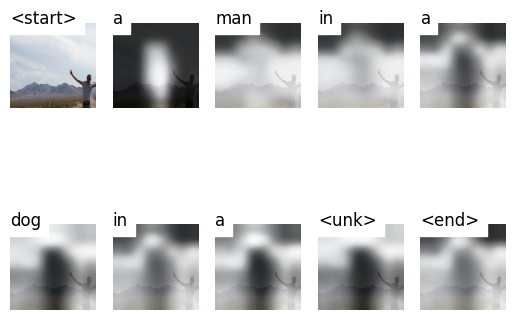

In [151]:
# 1.Load the model
best_checkpoint_path = 'checkpoint_best.pth'
checkpoint = torch.load(best_checkpoint_path, map_location=str(device))
decoder = checkpoint['decoder'].to(device)
encoder = checkpoint['encoder'].to(device)
decoder.eval()
encoder.eval()

# 2.Load vocab
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
    
# 3.Read and preprocess image
image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
random_img_name = random.choice(os.listdir(image_folder))
img_path = image_folder + random_img_name
img = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])
img = transform(img)  # (3, 256, 256)

# 4.Encode, decode with attention and beam search
beam_size = 3
seq, alphas = generate_caption_beam_search(encoder, decoder, img, vocab, beam_size)
alphas = torch.FloatTensor(alphas)

# 5.Visualize caption and attention of best sequence
visualize_att(img_path, seq, alphas, vocab, smooth=True)

# TTS

# Save outputs for next time

In [ ]:
!zip -r saved_data.zip /kaggle/working/